**Aim**: Finding the best fit of the rotation curve of a disk galaxy and determine the mass of the dark matter halo.

There are two data file extract from the web app. `NGC2403_rot_cur.txt` and `UGC128_rot_cur.txt`

There are **three** parameters to fit:
- Halo Central Density: 0~500 Solar masses/(10pc)^3
- Halo Core Radius: 0~5 kpc
- Disk Mass to Light Ratio: 0~5 solar masses/solar luminosity


[The web app](http://pages.pomona.edu/~tmoore/RotCurve/)

[The theory web](https://pages.pomona.edu/~tmoore/RotCurve/Website/)

Notice: 
- we use a slightly different formular to calculate the rotation of disk compare to the app
- Be careful to the parameters' units. 

$$V_{tot}^2=V_{halo}^2+V_{disk}^2$$
$$V_{halo}^2(r)=4\pi G \rho_0r^2_c\bigg[1-\frac{r_c}{r}arctan(\frac{r}{r_c})\bigg]$$
$$V_{disk}(r)=0.85*\sqrt{G\times M2L \times L/R0}\sqrt{\frac{\tilde{r}^{1.3}}{1+\tilde{r}^{2.3}}}\qquad \tilde{r}=0.533/2\times r/R_0$$
- R0 in unit of parsec
- the rest is in the unit of SI unit

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [73]:
# in SI unit
m_solar=1.98847e30      # kg
pc=3.08567758e16        # m
kpc=pc*1e3
G=6.67430*1e-11
pi=np.pi
# 
# N2403
L_N2403=2.45*1e9
R0_N2403=1              # kpc

# U128
L_U128=1.95*1e9         # Luminosity of sun
R0_U128=3.5             # kpc

In [217]:
def read_data(f_loc):
    f=open(f_loc)
    data=f.read().split('\n')
    df=pd.DataFrame(columns=['R_kpc','vrot_km/s','vrot_err'],dtype=np.float64)
    for i in range(1,len(data)):
        temp_str_ls=data[i].split(' ')
        temp_ls=[]
        for item in temp_str_ls:
            if item!='':
                temp_ls.append(eval(item))
        df.loc[i,:]=temp_ls
    return df

def get_Vdisk(r,M2L,L0,R0):
    # r: per kilo parsecs
    # R0: per kilo parsecs
    # v: km/s
    r_tilde=0.533/2*r/R0
    cal1=np.sqrt(r_tilde**1.3/(1+r_tilde**2.3))
    vdisk=0.85*np.sqrt(M2L*G*m_solar*L0/(R0*kpc))*cal1/1e3
    return vdisk

def get_Vhalo(r,rho0,rc):
    # r: per kilo parsecs
    # rho0: solar mass/(10pc)^3
    # rc: per kilo parsecs
    rho0_SI=rho0*m_solar/(10*pc)**3
    rc_SI=rc*kpc
    vhalo=np.sqrt(4*pi*G*rho0_SI*rc_SI**2*(1-rc/r*np.arctan(r/rc)))/1e3
    # vhalo=np.sqrt(4*pi*G*rho0_SI*rc_SI**2*(1-rc/r*np.arctan(r/rc)))
    return vhalo

def get_Vtot(vhalo,vdisk):
    vtot=np.sqrt(vhalo**2+vdisk**2)
    return vtot

def func_to_fit_N2403(r,rho0,rc,M2L):
    vhalo=get_Vhalo(r,rho0,rc)
    vdisk=get_Vdisk(r,M2L,**{'L0':L_N2403,'R0':R0_N2403})
    vtot=get_Vtot(vhalo,vdisk)
    return vtot

def func_to_fit_U128(r,rho0,rc,M2L):
    vhalo=get_Vhalo(r,rho0,rc)
    vdisk=get_Vdisk(r,M2L,**{'L0':L_U128,'R0':R0_U128})
    vtot=get_Vtot(vhalo,vdisk)
    return vtot    

def get_chi2(real,err,pred):
    chi2=np.sum(((real-pred)/err)**2)
    return chi2

def get_plot(df,popt,chi2,title_str,save_loc=None):
    legend_str='$\\rho_0$: {:<.0f}$M_\odot/(10pc)^3$\n$R_c$: {:<.2f}kpc\nM2L: {:<.2f}\nChi2: {:<.2f}'.format(*popt,chi2)
    plt.figure(figsize=(8,6),dpi=300)
    plt.errorbar(df.R_kpc,df['vrot_km/s'],df['vrot_err'],fmt='o--',label='obs_data')
    plt.plot(df.R_kpc,df.vdisk,color='green',label='Disk')
    plt.plot(df.R_kpc,df.vhalo,color='orange',label='Halo')
    plt.plot(df.R_kpc,df.vrot_pred,color='red',label='Total')
    plt.legend(loc='center right',title=legend_str)
    plt.title(title_str)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Radius in kpc')
    plt.ylabel('Rotation speed in km/s')
    plt.tight_layout()
    if type(save_loc)==str: plt.savefig(save_loc)
    plt.show()
    return None

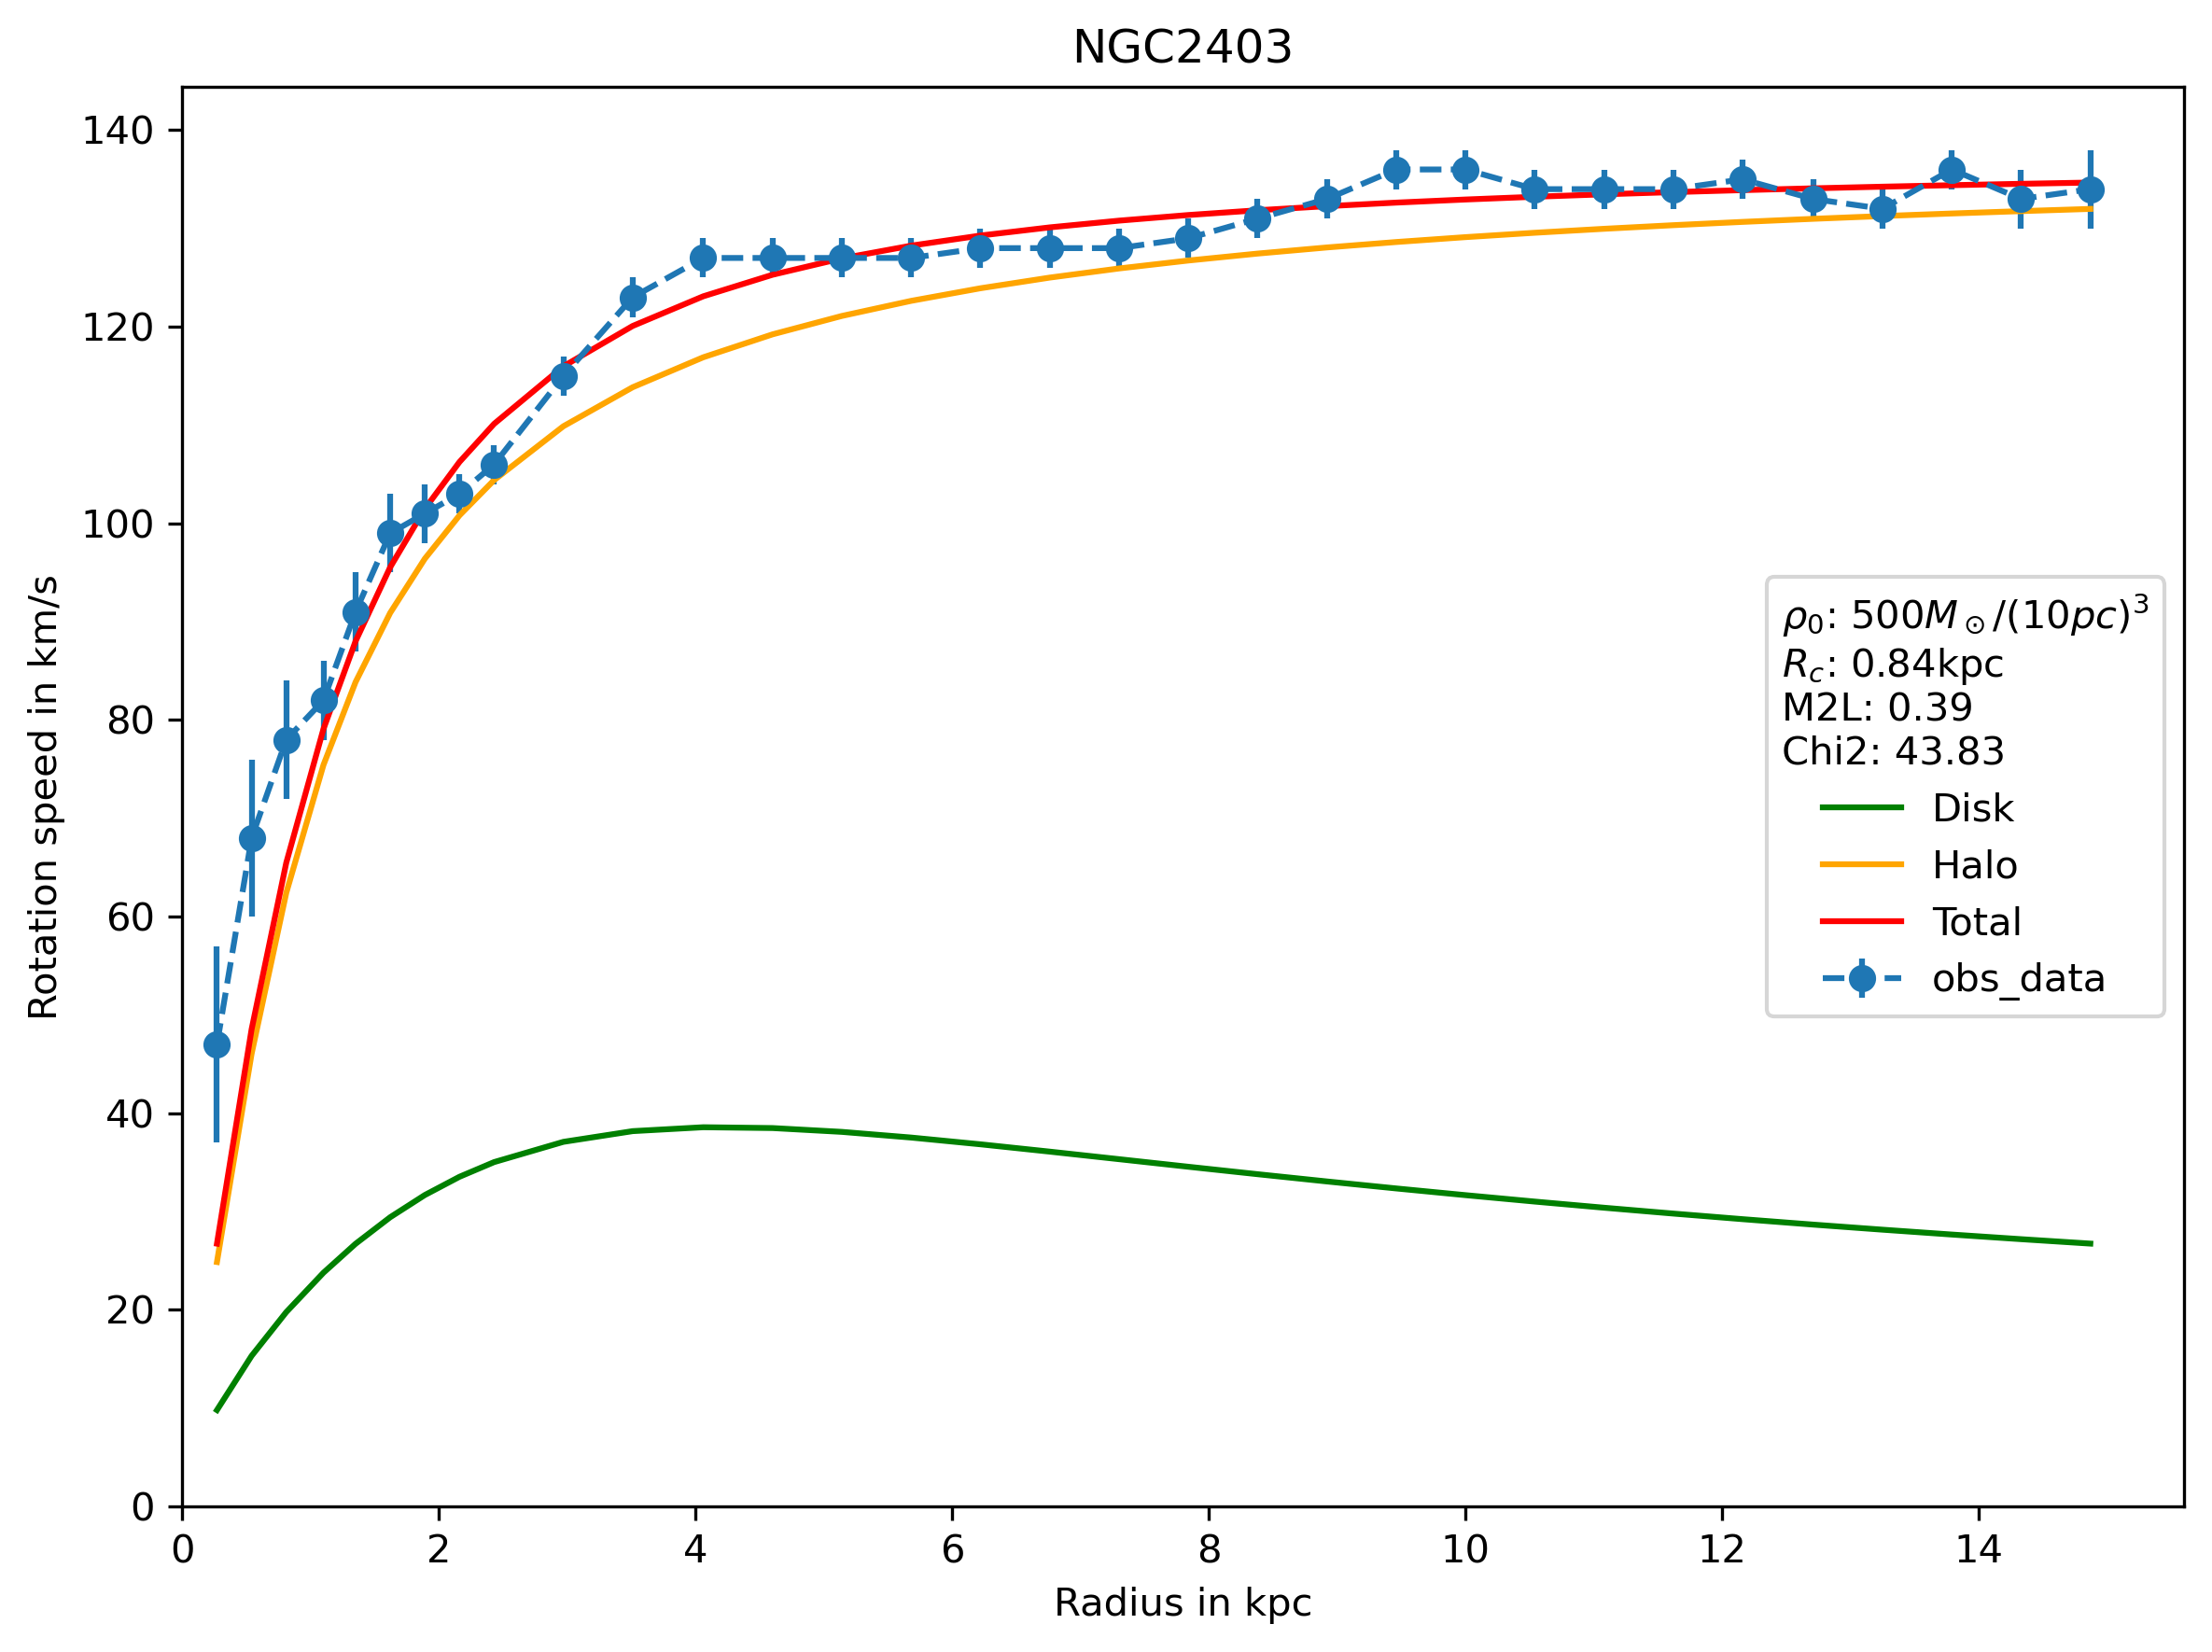

In [220]:
df=read_data('NGC2403_rot_cur.txt')
popt,pocv=curve_fit(func_to_fit_N2403,df['R_kpc'].values,df['vrot_km/s'].values,\
    sigma=df['vrot_err'].values,bounds=([0,0,0],[500,5,5]))
df['vdisk']=get_Vdisk(df['R_kpc'].values,popt[2],**{'L0':L_N2403,'R0':R0_N2403})
df['vhalo']=get_Vhalo(df['R_kpc'].values,popt[0],popt[1])
df['vrot_pred']=get_Vtot(df['vhalo'].values,df['vdisk'].values)
chi2=get_chi2(df['vrot_km/s'].values,df['vrot_err'].values,df['vrot_pred'].values)
get_plot(df,popt,chi2,title_str='NGC2403',save_loc='NGC2403.png')

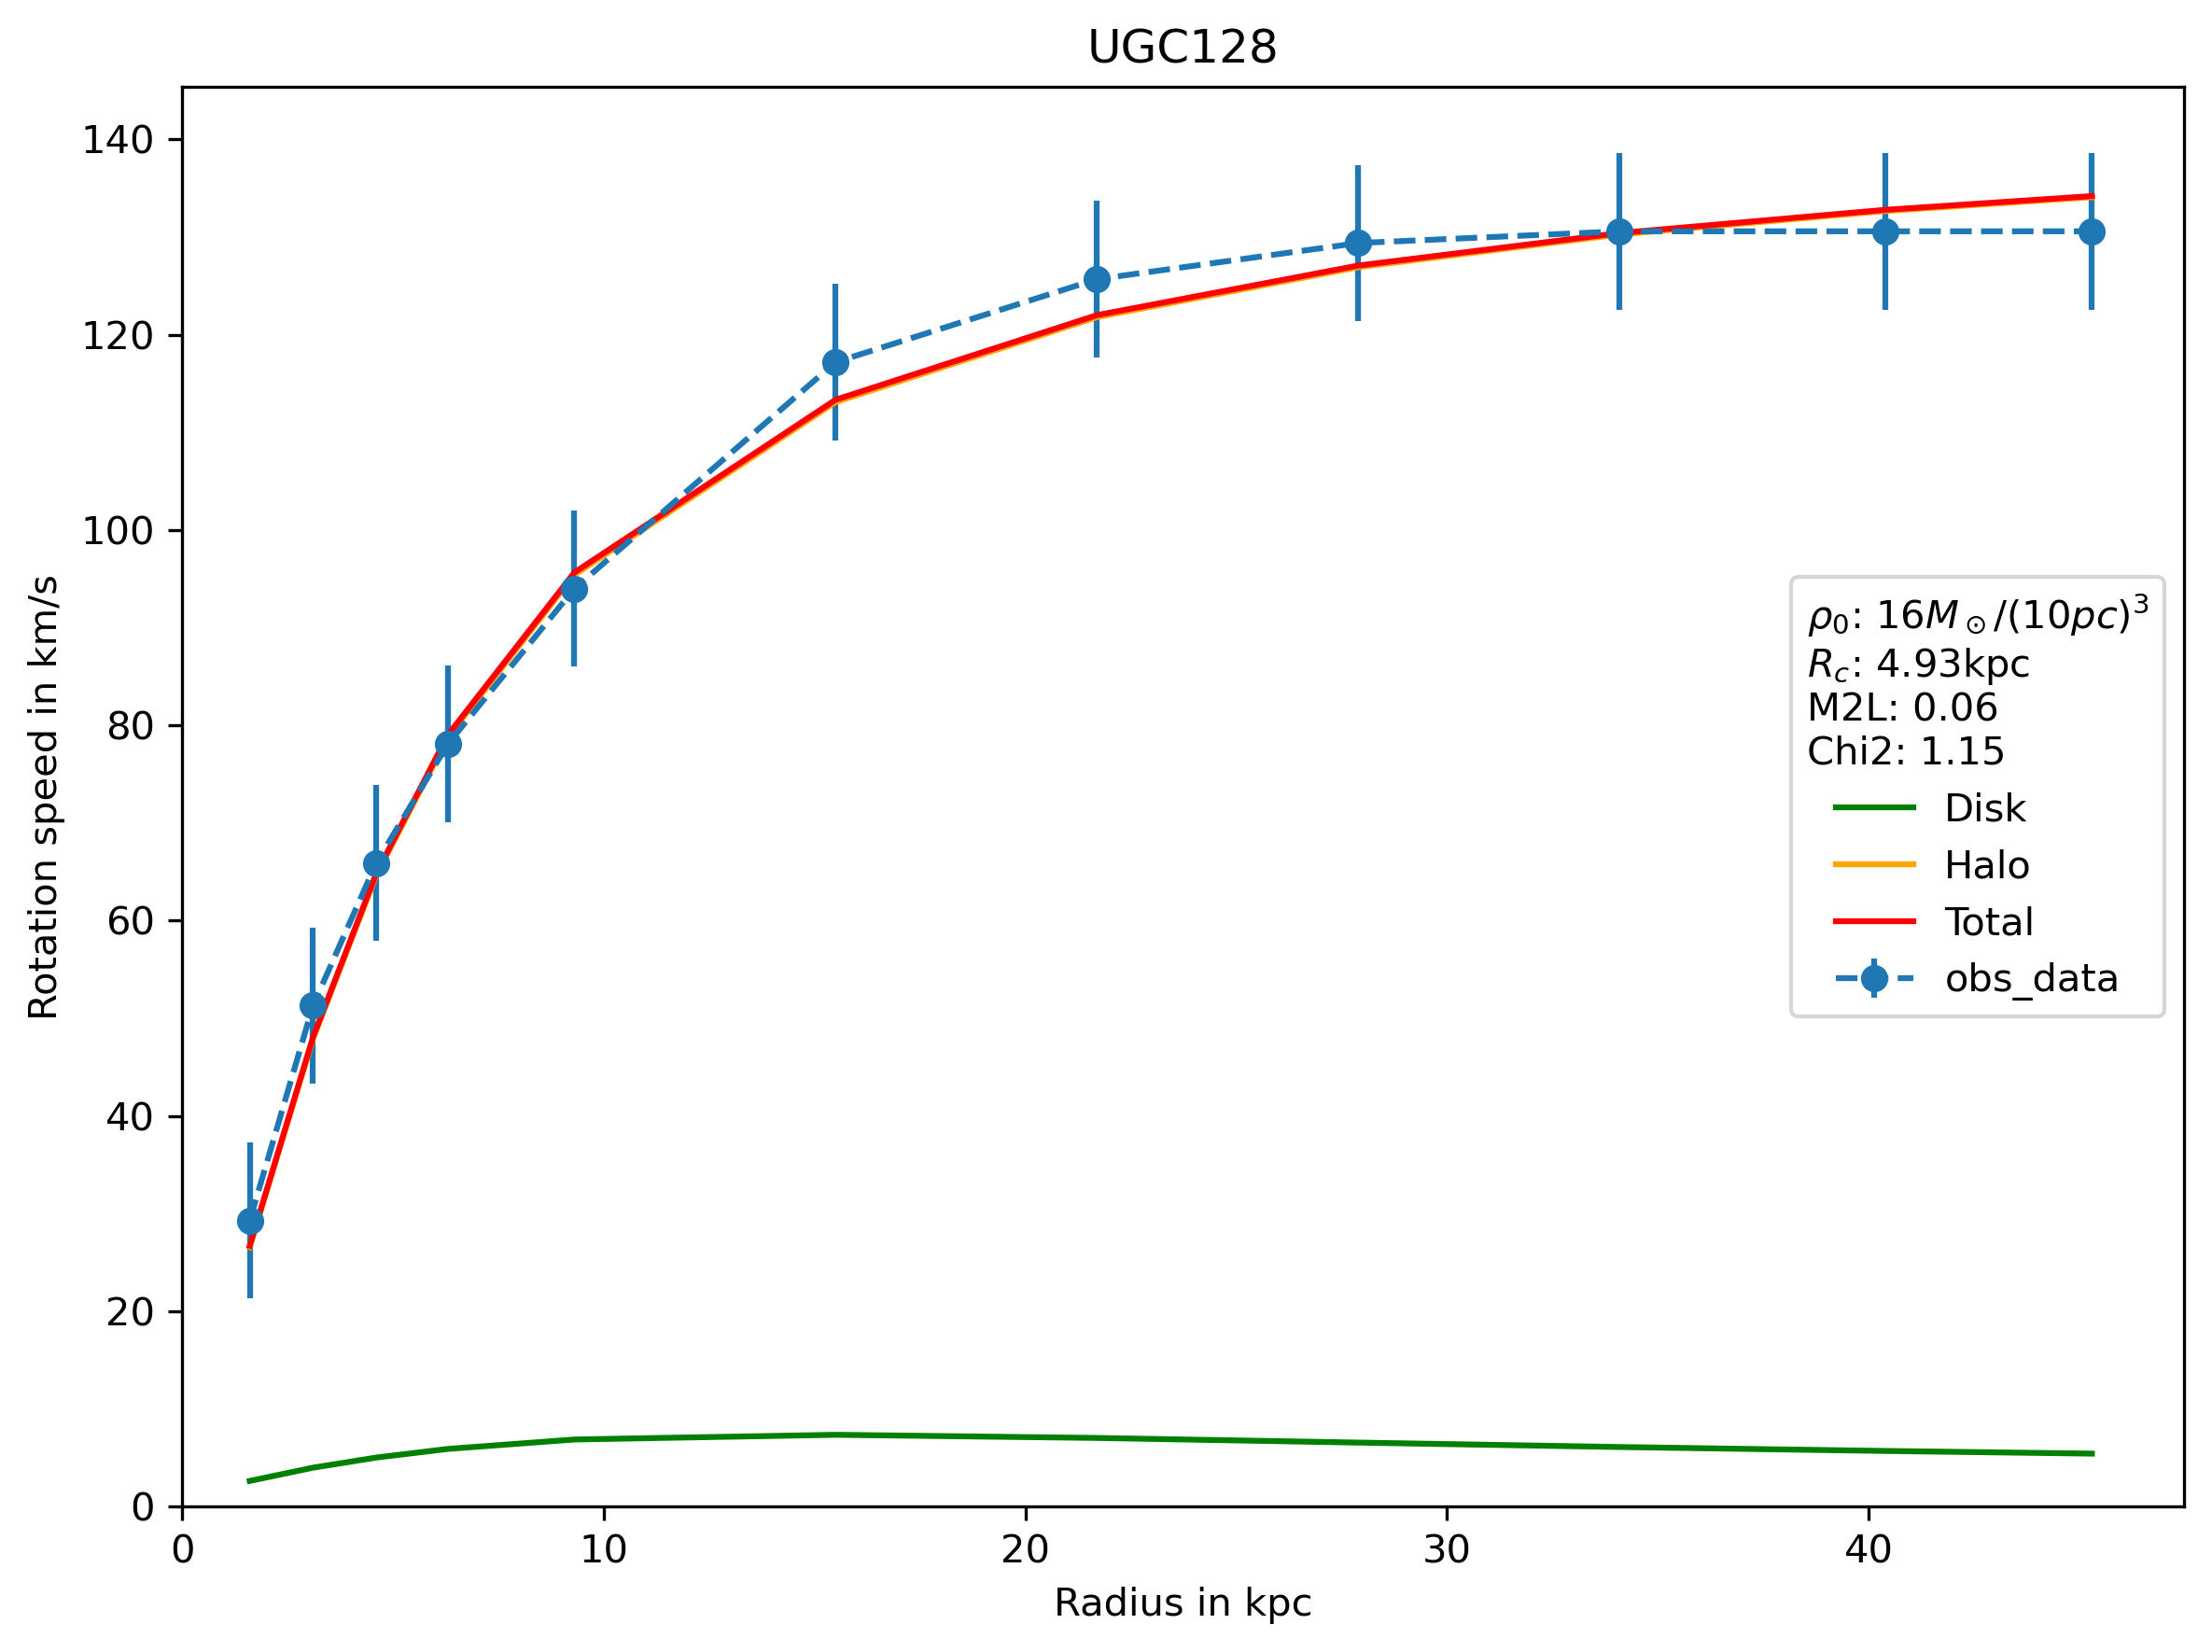

In [221]:
df=read_data('UGC128_rot_cur.txt')
popt,pocv=curve_fit(func_to_fit_N2403,df['R_kpc'].values,df['vrot_km/s'].values,\
    sigma=df['vrot_err'].values,bounds=([0,0,0],[500,5,5]))
df['vdisk']=get_Vdisk(df['R_kpc'].values,popt[2],**{'L0':L_U128,'R0':R0_U128})
df['vhalo']=get_Vhalo(df['R_kpc'].values,popt[0],popt[1])
df['vrot_pred']=get_Vtot(df['vhalo'].values,df['vdisk'].values)
chi2=get_chi2(df['vrot_km/s'].values,df['vrot_err'].values,df['vrot_pred'].values)
get_plot(df,popt,chi2,title_str='UGC128',save_loc='UGC128.png')